In [88]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt

Calibration images with checkerboad corners shown


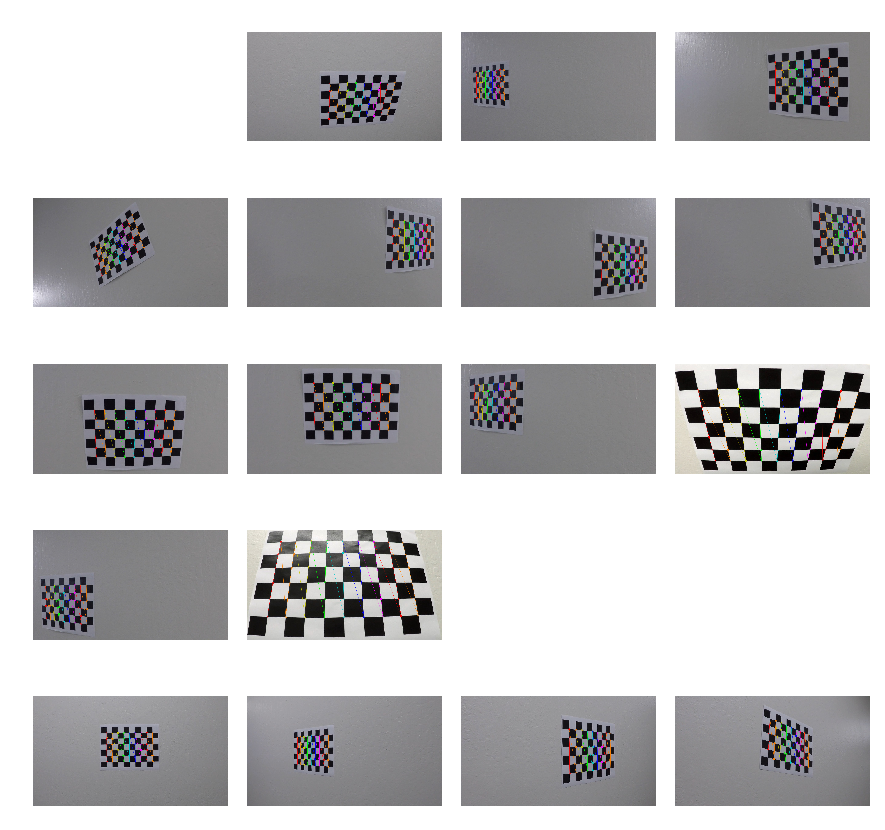

In [89]:
# calibrate camera based on https://docs.opencv.org/3.3.1/dc/dbb/tutorial_py_calibration.html
    
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./camera_cal/*.jpg')
row=0
col=0
f, axarr = plt.subplots(5, 4)
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (6,9), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (6,9), corners2, ret)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #add image to subplot    
        axarr[row, col].imshow(img_rgb)
    axarr[row, col].axis('off')
    col += 1
    if col==4:
        row +=1
        col=0
        
#caclulate cal matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)        
        
#4x5 subplot of the 20 cal images with corners drawn        
f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)
print('Calibration images with checkerboad corners shown')
plt.show()



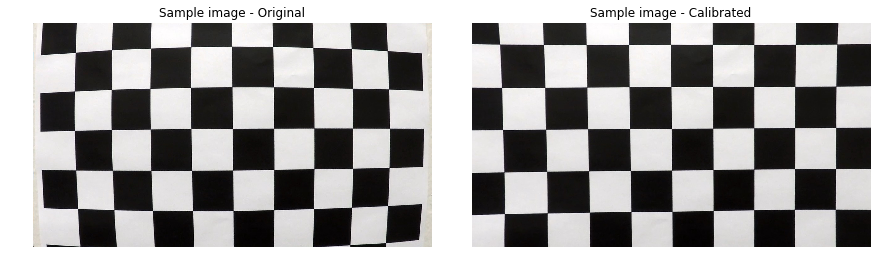

In [90]:
# read in a sample image and display it along with an undistorted version
img = cv2.imread('./camera_cal/calibration1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(img_rgb)
axarr[0].axis('off')
axarr[0].title.set_text('Sample image - Original')

# undistort
undist = cv2.undistort(img_rgb, mtx, dist, None, mtx)

axarr[1].imshow(undist)
axarr[1].axis('off')
axarr[1].title.set_text('Sample image - Calibrated')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()


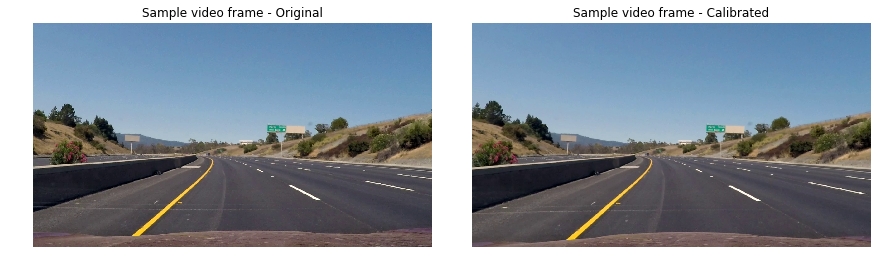

In [91]:
# open video and grab first frame

cap = cv2.VideoCapture("./project_video.mp4")
ret, frame = cap.read()
cap.release()


frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# read in a sample image and display it along with an undistorted version

img_rgb = frame

f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(img_rgb)
axarr[0].axis('off')
axarr[0].title.set_text('Sample video frame - Original')

# undistort
undist = cv2.undistort(img_rgb, mtx, dist, None, mtx)

axarr[1].imshow(undist)
axarr[1].axis('off')
axarr[1].title.set_text('Sample video frame - Calibrated')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()


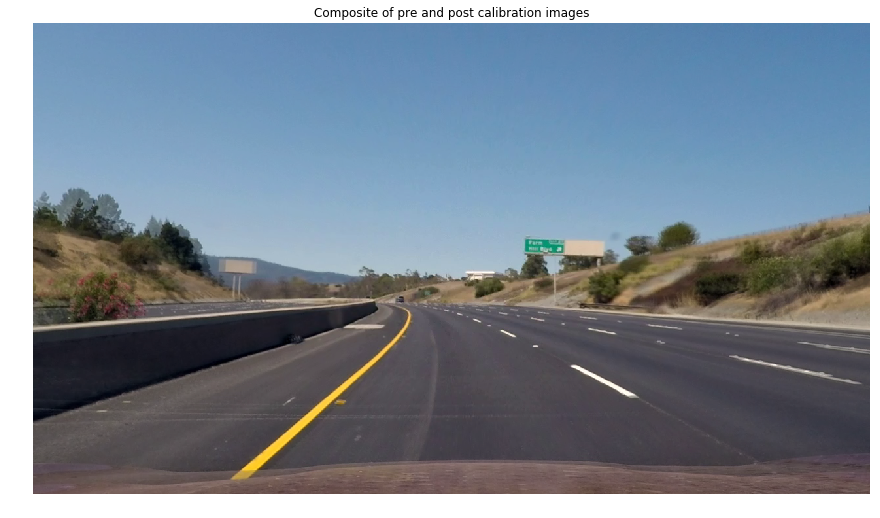

In [92]:
#display a composite of the original and calibrated images
alpha = 0.5
beta = (0.5)
dst = cv2.addWeighted( img_rgb, alpha, undist, beta, 0.0)
fig = plt.figure(figsize= (15,15))
plt.imshow(dst)
plt.axis('off')
plt.title('Composite of pre and post calibration images')
plt.show()


In [93]:
#transformer perspective of the image to birds-eye
def warp_frame(img):
    src = np.float32([[525,470], [775,470], [1390,700], [0,700]])
    dst = np.float32([[0,0], [1279,0], [1279,719], [0,719]])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img,M,(1280,720))
    return warped

In [94]:
#draw a trapozoid around the area that gets transformed to birds-eye
def draw_box(img):
    cv2.line(img,(525,470),(775,470),(0,255,0),4)
    cv2.line(img,(775,470),(1390,690),(0,255,0),4)
    cv2.line(img,(1390,700),(0,700),(0,255,0),4)
    cv2.line(img,(0,700),(525,470),(0,255,0),4)
    return(img)

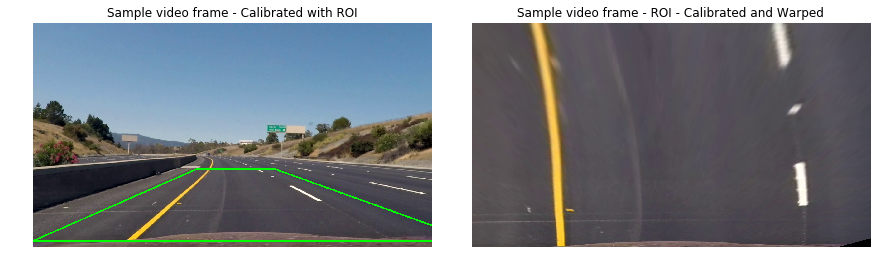

In [95]:
#visualize perspective warp and draw a box around the ROI
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(draw_box(undist.copy()))
axarr[0].axis('off')
axarr[0].title.set_text('Sample video frame - Calibrated with ROI')

axarr[1].imshow(warp_frame(undist))
axarr[1].axis('off')
axarr[1].title.set_text('Sample video frame - ROI - Calibrated and Warped')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

In [96]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    if orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel=np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_sobel = (abs_sobel * 255 / np.max(abs_sobel)).astype(np.uint8)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    msk = ((scale_sobel <= thresh_max) & (scale_sobel >= thresh_min))       
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(msk)
    
    return binary_output

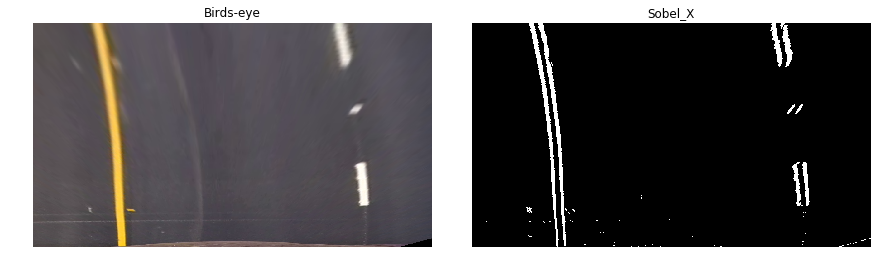

In [97]:
#visualize sobel x
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(warp_frame(undist))
axarr[0].axis('off')
axarr[0].title.set_text('Birds-eye')

axarr[1].imshow(abs_sobel_thresh(warp_frame(undist), orient='x', thresh_min=25, thresh_max=255), cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('Sobel_X')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

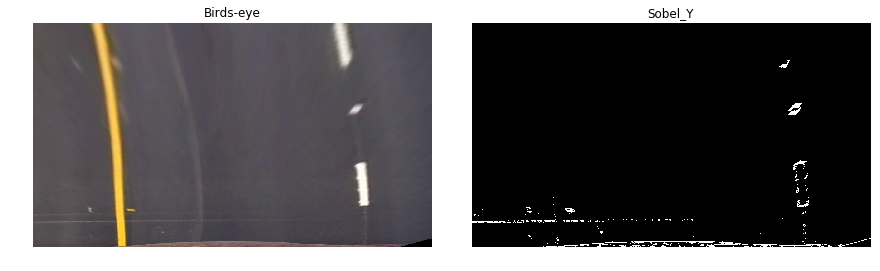

In [98]:
#visualize sobel y
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(warp_frame(undist))
axarr[0].axis('off')
axarr[0].title.set_text('Birds-eye')

axarr[1].imshow(abs_sobel_thresh(warp_frame(undist), orient='y', thresh_min=25, thresh_max=255), cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('Sobel_Y')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

In [99]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_mag = (mag * 255 / np.max(mag)).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    msk = ((scale_mag >= mag_thresh[0]) & (scale_mag <= mag_thresh[1]))       
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(msk)
    
    return binary_output

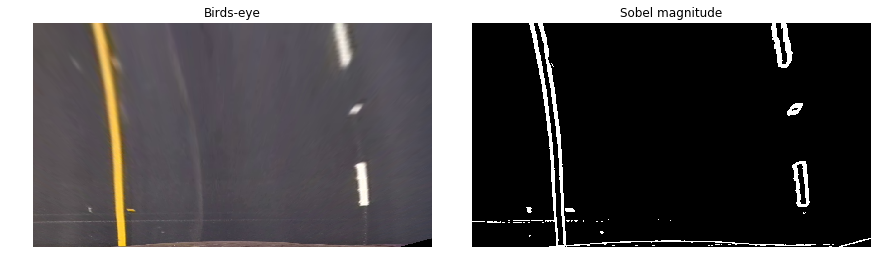

In [100]:
#visualize magnitude of sobel 
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(warp_frame(undist))
axarr[0].axis('off')
axarr[0].title.set_text('Birds-eye')

axarr[1].imshow(mag_thresh(warp_frame(undist), sobel_kernel=9, mag_thresh=(30,255)), cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('Sobel magnitude')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

In [101]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    msk = ((angle >= thresh[0]) & (angle <= thresh[1]))       
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(msk)
    
    return binary_output

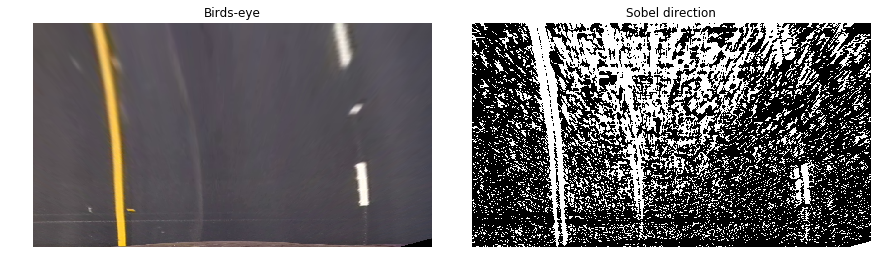

In [102]:
#visualize direction of sobel 
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(warp_frame(undist))
axarr[0].axis('off')
axarr[0].title.set_text('Birds-eye')

axarr[1].imshow(dir_thresh(warp_frame(undist), sobel_kernel=15, thresh=(0, 0.4)), cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('Sobel direction')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

In [103]:
#test soble parameters if enabled - generate sobel_test.mp4 to show each stage
sobel_test = False

if sobel_test:

    vid_name = "./project_video.mp4"
    #vid_name = "./challenge_video.mp4"
    #vid_name = "./harder_challenge_video.mp4"

    cap = cv2.VideoCapture(vid_name)
    out = cv2.VideoWriter('./sobel_test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (1280,720))

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
               
            original = cv2.resize(frame, (640, 360))      
        
            undist = cv2.undistort(frame, mtx, dist, None, mtx)
        
            warped = warp_frame(undist)
        
            undist_box = draw_box(undist.copy())
        
            sobelx_bin = abs_sobel_thresh(warp_frame(undist), orient='x', thresh_min=25, thresh_max=255)
            sobelx_img = undist.copy()
            sobelx_img[:,:,0] = np.uint8(sobelx_bin*255)
            sobelx_img[:,:,1] = np.uint8(sobelx_bin*255)
            sobelx_img[:,:,2] = np.uint8(sobelx_bin*255)
        
            sobely_bin = abs_sobel_thresh(warp_frame(undist), orient='y', thresh_min=25, thresh_max=255)
            sobely_img = undist.copy()
            sobely_img[:,:,0] = np.uint8(sobely_bin*255)
            sobely_img[:,:,1] = np.uint8(sobely_bin*255)
            sobely_img[:,:,2] = np.uint8(sobely_bin*255)
        
            sobelm_bin = mag_thresh(warp_frame(undist), sobel_kernel=9, mag_thresh=(30,255))
            sobelm_img = undist.copy()
            sobelm_img[:,:,0] = np.uint8(sobelm_bin*255)
            sobelm_img[:,:,1] = np.uint8(sobelm_bin*255)
            sobelm_img[:,:,2] = np.uint8(sobelm_bin*255)
        
            sobeld_bin = dir_thresh(warp_frame(undist), sobel_kernel=15, thresh=(0, 0.4))
            sobeld_img = undist.copy()
            sobeld_img[:,:,0] = np.uint8(sobeld_bin*255)
            sobeld_img[:,:,1] = np.uint8(sobeld_bin*255)
            sobeld_img[:,:,2] = np.uint8(sobeld_bin*255)
        
            sobelc_bin = (sobelx_bin | sobely_bin | sobelm_bin) & sobeld_bin
            sobelc_img = undist.copy()
            sobelc_img[:,:,0] = np.uint8(sobelc_bin*255)
            sobelc_img[:,:,1] = np.uint8(sobelc_bin*255)
            sobelc_img[:,:,2] = np.uint8(sobelc_bin*255)
        
            final = cv2.resize(undist, (640, 360))
        
            process1a = cv2.resize(undist_box, (320, 180))
            process1b = cv2.resize(warped, (320, 180))
            process2a = cv2.resize(sobelx_img, (320, 180))
            process2b = cv2.resize(sobely_img, (320, 180))
            process3a = cv2.resize(sobelm_img, (320, 180))
            process3b = cv2.resize(sobeld_img, (320, 180))
            process4a = cv2.resize(sobelc_img, (320, 180))
            process4b = cv2.resize(frame, (320, 180))
        
            concat1 = np.concatenate((process1a, process1b), axis=1)
            concat2 = np.concatenate((process2a, process2b), axis=1)
            concat3 = np.concatenate((process3a, process3b), axis=1)
            concat4 = np.concatenate((process4a, process4b), axis=1)
        
            concat5 = np.concatenate((concat1, concat2), axis=0)
            concat6 = np.concatenate((concat5, concat3), axis=0)
            concat7 = np.concatenate((concat6, concat4), axis=0)
        
            concat8 = np.concatenate((original, final), axis=0)
        
            concat9 = np.concatenate((concat8, concat7), axis=1)
            
            out.write(concat9)

            cv2.imshow('frame',concat9) #new_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [104]:
#threshold for s channel of HLS image
def s_thresh(img, thresh = (100,255)):

    # 1) Convert to HLS
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) extract saturation channel
    S = hls[:,:,2]
    # 3) make binary of all zeros same shape as S
    binary_output = np.zeros_like(S)
    # 4) make binary based on thresholds
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary_output

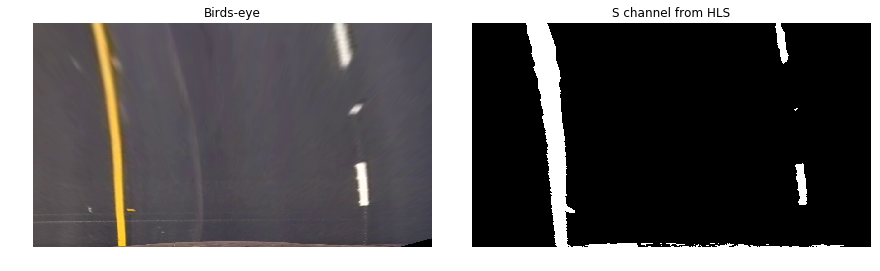

In [105]:
#visualize s_thresh for HLS image
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(warp_frame(undist))
axarr[0].axis('off')
axarr[0].title.set_text('Birds-eye')

axarr[1].imshow(s_thresh(warp_frame(undist), thresh = (30, 255)), cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('S channel from HLS')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

In [106]:
#threshold for h channel of HLS image
def h_thresh(img, thresh = (100,255)):

    # 1) Convert to HLS
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) extract saturation channel
    H = hls[:,:,0]
    # 3) make binary of all zeros same shape as S
    binary_output = np.zeros_like(H)
    # 4) make binary based on thresholds
    binary_output[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    return binary_output

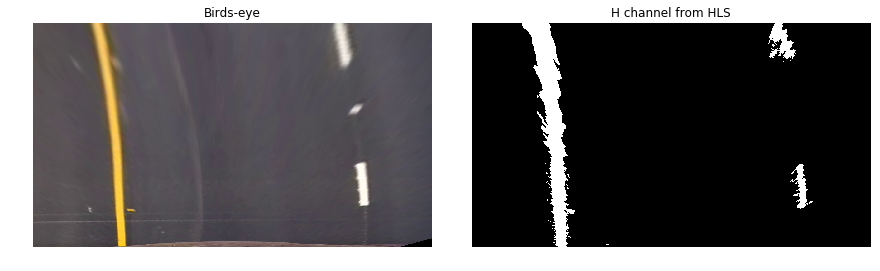

In [107]:
#visualize h_thresh for HLS image
f, axarr = plt.subplots(1,2) #1x2 subplot

axarr[0].imshow(warp_frame(undist))
axarr[0].axis('off')
axarr[0].title.set_text('Birds-eye')

axarr[1].imshow(h_thresh(warp_frame(undist), thresh = (15, 100)), cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('H channel from HLS')

f.subplots_adjust(hspace = .1, wspace = .1)   
f.set_figheight(15)
f.set_figwidth(15)

plt.show()

In [108]:
#test HLS parameters if enabled - generate hls_test.mp4 to show each stage
hls_test = False

if hls_test:

    vid_name = "./project_video.mp4"
    #vid_name = "./challenge_video.mp4"
    #vid_name = "./harder_challenge_video.mp4"

    cap = cv2.VideoCapture(vid_name)
    out = cv2.VideoWriter('./hls_test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (1280,720))

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
               
            original = cv2.resize(frame, (640, 360))      
        
            undist = cv2.undistort(frame, mtx, dist, None, mtx)
        
            warped = warp_frame(undist)
        
            undist_box = draw_box(undist.copy())
        
            s_bin = s_thresh(warp_frame(undist), thresh=(30,255))
            s_img = undist.copy()
            s_img[:,:,0] = np.uint8(s_bin*255)
            s_img[:,:,1] = np.uint8(s_bin*255)
            s_img[:,:,2] = np.uint8(s_bin*255)
        
            h_bin = h_thresh(warp_frame(undist), thresh = (15, 100))
            h_img = undist.copy()
            h_img[:,:,0] = np.uint8(h_bin*255)
            h_img[:,:,1] = np.uint8(h_bin*255)
            h_img[:,:,2] = np.uint8(h_bin*255)
        
        
            sh_bin = (s_bin | h_bin)
            sh_img = undist.copy()
            sh_img[:,:,0] = np.uint8(sh_bin*255)
            sh_img[:,:,1] = np.uint8(sh_bin*255)
            sh_img[:,:,2] = np.uint8(sh_bin*255)
        
            final = cv2.resize(undist, (640, 360))
        
            process1a = cv2.resize(undist_box, (320, 180))
            process1b = cv2.resize(warped, (320, 180))
            process2a = cv2.resize(s_img, (320, 180))
            process2b = cv2.resize(h_img, (320, 180))
            process3a = cv2.resize(sh_img, (320, 180))
            process3b = cv2.resize(frame, (320, 180))
            process4a = cv2.resize(frame, (320, 180))
            process4b = cv2.resize(frame, (320, 180))
        
            concat1 = np.concatenate((process1a, process1b), axis=1)
            concat2 = np.concatenate((process2a, process2b), axis=1)
            concat3 = np.concatenate((process3a, process3b), axis=1)
            concat4 = np.concatenate((process4a, process4b), axis=1)
        
            concat5 = np.concatenate((concat1, concat2), axis=0)
            concat6 = np.concatenate((concat5, concat3), axis=0)
            concat7 = np.concatenate((concat6, concat4), axis=0)
        
            concat8 = np.concatenate((original, final), axis=0)
        
            concat9 = np.concatenate((concat8, concat7), axis=1)
            
            out.write(concat9)

            cv2.imshow('frame',concat9) #new_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [122]:
def find_lines(binary_warped, p_left_fit, p_right_fit):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,127,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,127,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #print(right_fit[2])
    
    lk=.2
    rk=.1
    if abs(left_fit[0])>.001:
        lk=0
    if abs(right_fit[0])>.001:
        rk=0
    if abs(left_fit[1])>.6:
        lk=0
    if abs(right_fit[1])>.6:
        rk=0  
    if (left_fit[2]<0) | (left_fit[2]>250):
        lk=0
    if (right_fit[2]<400) | (right_fit[2]>650):
        rk=0      
        
        
    for i in range(3):
        left_fit[i] = (left_fit[i] * lk) + (p_left_fit[i] * (1-lk))
        right_fit[i] = (right_fit[i] * rk) + (p_right_fit[i] * (1-rk))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [127, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 127]
    
    line_only_img = np.dstack((binary_warped, binary_warped, binary_warped))*0
    
    for i in range(ploty.shape[0]):
        cv2.line(out_img,(int(left_fitx[i]),int(ploty[i])),(int(left_fitx[i]),int(ploty[i])),(0,255,255),3)
        cv2.line(out_img,(int(right_fitx[i]),int(ploty[i])),(int(right_fitx[i]),int(ploty[i])),(0,255,255),3)
        
        cv2.line(line_only_img,(int(left_fitx[i]),int(ploty[i])),(int(left_fitx[i]),int(ploty[i])),(0,255,0),10)
        cv2.line(line_only_img,(int(right_fitx[i]),int(ploty[i])),(int(right_fitx[i]),int(ploty[i])),(0,255,0),10)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Calculate curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 1
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', (((left_fit[2]+right_fit[2])/2)-325)/400*3.7, "m right center")
    # Example values: 632.1 m    626.2 m
        
    return color_warp, line_only_img, out_img, left_fit, right_fit

In [123]:
#transformer perspective of the image to birds-eye
def warp_back(img):
    #src = np.float32([[525,470], [775,470], [1390,700], [0,700]])
    #dst = np.float32([[0,0], [1279,0], [1279,719], [0,719]])
    
    src = np.float32([[0,0], [639,0], [639,360], [0,360]])
    dst = np.float32([[525,470], [775,470], [1390,700], [0,700]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    warped_back = cv2.warpPerspective(img,M,(1280,720))
    return warped_back

In [125]:
#test sobel with HLS parameters if enabled - generate sobel_hls_test.mp4 to show each stage  *** processing done at 640x360 for speed up

sobel_hls_test = True

if sobel_hls_test:

    vid_name = "./project_video.mp4"
    #vid_name = "./challenge_video.mp4"
    #vid_name = "./harder_challenge_video.mp4"

    cap = cv2.VideoCapture(vid_name)
    out = cv2.VideoWriter('./pipeline.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (1280,720))
    out2 = cv2.VideoWriter('./lanelines_binary.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (640,360))
    out_final = cv2.VideoWriter('./final.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (1280,720))
    left_fit=[0,.2,100]
    right_fit=[0,.20,500]
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
               
            original = cv2.resize(frame, (640, 360))      
        
            undist = cv2.undistort(frame, mtx, dist, None, mtx)
        
            warped = warp_frame(undist)
        
            undist_box = draw_box(undist.copy())
            
            wf_small = cv2.resize(warp_frame(undist), (640,360))
            
            sobelx_bin = abs_sobel_thresh(wf_small, orient='x', thresh_min=25, thresh_max=255)
        
            sobely_bin = abs_sobel_thresh(wf_small, orient='y', thresh_min=25, thresh_max=255)
        
            sobelm_bin = mag_thresh(wf_small, sobel_kernel=5, mag_thresh=(30,255))
            
            sobeld_bin = dir_thresh(wf_small, sobel_kernel=9, thresh=(0, 0.4))
            
            sobelc_bin = (sobelx_bin | sobely_bin | sobelm_bin) & sobeld_bin
                 
            sobelc_img = wf_small.copy()
            sobelc_img[:,:,0] = np.uint8(sobelc_bin*255)
            sobelc_img[:,:,1] = np.uint8(sobelc_bin*255)
            sobelc_img[:,:,2] = np.uint8(sobelc_bin*255)
            
            s_bin = s_thresh(wf_small, thresh=(30,255))
        
            h_bin = h_thresh(wf_small, thresh = (15, 100))
        
            sh_bin = (s_bin | h_bin)
        
            kernel = np.ones((5,5), np.uint8)
            sh_bin_dil = cv2.dilate(sh_bin, kernel, iterations=1)
            
            sh_img = wf_small.copy()
            sh_img[:,:,0] = np.uint8(sh_bin_dil*255)
            sh_img[:,:,1] = np.uint8(sh_bin_dil*255)
            sh_img[:,:,2] = np.uint8(sh_bin_dil*255)
            
            sobel_sh_bin = (sobelc_bin & sh_bin_dil)
            sobel_sh_img = wf_small.copy()
            sobel_sh_img[:,:,0] = np.uint8(sobel_sh_bin*255)
            sobel_sh_img[:,:,1] = np.uint8(sobel_sh_bin*255)
            sobel_sh_img[:,:,2] = np.uint8(sobel_sh_bin*255)
            
            bin = sobel_sh_img[:340,:,0]
            color_warp, line_only_img, line_img, left_fit, right_fit = find_lines(bin, left_fit, right_fit)
            
            unwarped = warp_back(line_only_img)
            mask = unwarped.copy()
            mask[:,:,0] = mask[:,:,1]
            mask[:,:,2] = mask[:,:,1]
            mask = 255 - mask
            unwarped_poly = warp_back(color_warp)
            
            final = cv2.resize(cv2.addWeighted(cv2.bitwise_and(frame,mask)+unwarped, 1, unwarped_poly, 0.3, 0), (640, 360))
        
            process1a = cv2.resize(undist_box, (320, 180))
            process1b = cv2.resize(warped, (320, 180))
            process2a = cv2.resize(sobelc_img, (320, 180))
            process2b = cv2.resize(sh_img, (320, 180))
            process3a = cv2.resize(sobel_sh_img, (320, 180))
            process3b = cv2.resize(line_img, (320, 180))
            process4a = cv2.resize(line_only_img, (320, 180))
            process4b = cv2.resize(cv2.addWeighted(frame,0.7,unwarped,0.3,0), (320, 180))
        
            concat1 = np.concatenate((process1a, process1b), axis=1)
            concat2 = np.concatenate((process2a, process2b), axis=1)
            concat3 = np.concatenate((process3a, process3b), axis=1)
            concat4 = np.concatenate((process4a, process4b), axis=1)
        
            concat5 = np.concatenate((concat1, concat2), axis=0)
            concat6 = np.concatenate((concat5, concat3), axis=0)
            concat7 = np.concatenate((concat6, concat4), axis=0)
        
            concat8 = np.concatenate((original, final), axis=0)
        
            concat9 = np.concatenate((concat8, concat7), axis=1)
            
            out.write(concat9)
            out2.write(sobel_sh_img)
            out_final.write(cv2.addWeighted(cv2.bitwise_and(frame,mask)+unwarped, 1, unwarped_poly, 0.3, 0))
            cv2.imshow('frame',concat9) #new_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    out.release()
    out2.release()
    out_final.release()
    
    cv2.destroyAllWindows()

2676.46247332 m 3115.70419115 m -0.235049750328 m right center
1417.96721607 m 2222.264464 m -0.239237168735 m right center
1018.67166128 m 1646.859339 m -0.245604266627 m right center
817.756036994 m 1502.73720153 m -0.25124618558 m right center
710.75389383 m 1415.83263793 m -0.256713455196 m right center
642.600792948 m 1312.1030673 m -0.263849267107 m right center
594.634822652 m 2466.05783257 m -0.26180917586 m right center
563.519053478 m 3156.34109406 m -0.264626355722 m right center
546.586049046 m 4058.5965061 m -0.266249893863 m right center
529.018270189 m 2344.14453292 m -0.280169701458 m right center
509.63881655 m 1765.84398998 m -0.294954561666 m right center
501.371526163 m 1299.34305111 m -0.308172314584 m right center
501.368548325 m 1143.97382912 m -0.320407786045 m right center
499.504828935 m 1124.97182461 m -0.331961216592 m right center
504.825681525 m 1117.13804975 m -0.343841313173 m right center
510.528902812 m 1113.99621004 m -0.355939780011 m right center
52

451.965402732 m 650.920758096 m -0.425819148794 m right center
461.501494857 m 641.544275151 m -0.425967070662 m right center
467.474515559 m 673.264844258 m -0.424092753867 m right center
473.850384875 m 606.196313229 m -0.426497740184 m right center
482.467939996 m 582.294451758 m -0.427934082367 m right center
497.64111396 m 591.703429188 m -0.427224179834 m right center
517.3554851 m 592.285822915 m -0.425329661378 m right center
540.08926531 m 587.860649888 m -0.423070369761 m right center
568.762846448 m 610.262100874 m -0.419510315877 m right center
594.856946493 m 673.925083313 m -0.415187770733 m right center
611.204368867 m 757.257513579 m -0.410631772551 m right center
612.872262884 m 814.712060428 m -0.408688535314 m right center
602.338138763 m 919.750946703 m -0.404733934553 m right center
593.306704892 m 1001.98947695 m -0.401292559426 m right center
591.312451539 m 2048.49944405 m -0.386142945361 m right center
592.716794641 m 3067.63317133 m -0.382106607348 m right cen

727.093225052 m 606.494579232 m -0.617448214465 m right center
738.321068682 m 625.624655319 m -0.60660530922 m right center
728.975251455 m 645.981413013 m -0.596878423864 m right center
714.892587985 m 655.378178895 m -0.58688398176 m right center
704.36997033 m 628.350748292 m -0.5801580163 m right center
702.628549935 m 579.37349066 m -0.573805260635 m right center
696.986166707 m 525.358791826 m -0.572876696651 m right center
688.297407926 m 517.646729199 m -0.565717558709 m right center
676.089070509 m 547.139849992 m -0.557496599094 m right center
670.660182921 m 557.637165258 m -0.549949476342 m right center
663.342401089 m 569.850717858 m -0.542216547359 m right center
675.068260728 m 597.776566154 m -0.533221572614 m right center
676.093083302 m 634.917556725 m -0.524537351239 m right center
677.059868735 m 669.484296823 m -0.515607996948 m right center
680.725307812 m 695.235159157 m -0.507279618979 m right center
684.713041603 m 728.530105145 m -0.497546349197 m right cente

10195.2112498 m 1290.51758461 m -0.030823454103 m right center
51284.1690298 m 1369.27772575 m -0.0368340664523 m right center
39737.5097282 m 1390.88655892 m -0.0425282047651 m right center
31160.0119068 m 1487.32504806 m -0.0493485407813 m right center
94113.7577816 m 1463.65447663 m -0.0551577912992 m right center
10798.3742109 m 1428.50453998 m -0.0612415480745 m right center
5814.11212288 m 1390.02442571 m -0.0655036167578 m right center
3589.61098815 m 1046.85661361 m -0.0650955390142 m right center
2711.94482603 m 759.297184492 m -0.0622449026895 m right center
2292.32906312 m 696.336685005 m -0.0631685246929 m right center
1997.38913739 m 810.500583643 m -0.0736872900989 m right center
2057.41426895 m 925.643356748 m -0.0809653448144 m right center
2357.78631534 m 1034.79437914 m -0.0878141157215 m right center
2808.66360091 m 1113.71107927 m -0.0943208696871 m right center
3710.4013944 m 1128.98229989 m -0.0988803550359 m right center
5503.00185588 m 1087.7500502 m -0.10207651

11129.5346008 m 1016.25780696 m -0.111702523287 m right center
13328.0810939 m 1153.92116042 m -0.111726832986 m right center
29464.0410671 m 1351.82125008 m -0.112372606708 m right center
55409.1625393 m 1466.33839581 m -0.113706912138 m right center
197540.388037 m 1529.0624679 m -0.114521734786 m right center
44685.5508579 m 1598.66681225 m -0.110826514032 m right center
49577.8445984 m 1665.27357259 m -0.106353629871 m right center
17260.5065824 m 1244.65609838 m -0.0948290278005 m right center
8756.69541467 m 1541.32894281 m -0.0915215842157 m right center
13647.9362232 m 1748.45452794 m -0.0910827212192 m right center
34616.7439228 m 1658.30866448 m -0.0920805758629 m right center
110684.233971 m 1767.54867097 m -0.093610757305 m right center
8763.97283074 m 1900.1291539 m -0.0947423836436 m right center
6379.52015364 m 1840.68161277 m -0.0956213226316 m right center
5540.87413101 m 2376.05777535 m -0.0974576088134 m right center
6523.22341357 m 2386.18789862 m -0.0957044036384 m

1183.74718985 m 464.567327807 m 0.395340239177 m right center
1078.54570073 m 515.257736642 m 0.393697573936 m right center
955.063069632 m 531.163565109 m 0.392985435913 m right center
850.531021531 m 575.460640685 m 0.393926280418 m right center
792.737647413 m 597.780455643 m 0.392335652321 m right center
721.297223249 m 636.716137849 m 0.391886927855 m right center
679.960554602 m 613.648539387 m 0.391170525634 m right center
632.802240046 m 590.764646907 m 0.390282822635 m right center
598.929598739 m 566.821910994 m 0.390945258881 m right center
573.354572439 m 529.799205857 m 0.393728991403 m right center
562.758008024 m 521.648212898 m 0.395287937558 m right center
556.035787498 m 521.648212898 m 0.398569722747 m right center
551.604877878 m 451.910066865 m 0.411126595576 m right center
553.388987373 m 503.073702092 m 0.409258810565 m right center
560.1522614 m 554.918510316 m 0.40210382641 m right center
568.858864089 m 591.105895443 m 0.396676268379 m right center
581.3794832

784.385807522 m 425.016322073 m 0.662291191414 m right center
799.734353097 m 439.11346957 m 0.654524198346 m right center
804.970228162 m 469.188229421 m 0.646848985874 m right center
776.837081489 m 495.680932444 m 0.640475719606 m right center
740.269818565 m 479.584243651 m 0.637303432864 m right center
732.5695653 m 461.351331558 m 0.633152178111 m right center
725.42932932 m 446.879905962 m 0.629823856223 m right center
734.263603446 m 413.86618945 m 0.628398184616 m right center
759.886643618 m 371.638877597 m 0.629678246839 m right center
807.959707544 m 386.161210778 m 0.617808957796 m right center
879.29348722 m 384.117992173 m 0.611664475703 m right center
986.068306582 m 417.051351885 m 0.59762578484 m right center
1150.62288281 m 427.325110085 m 0.584783443945 m right center
1375.02071286 m 444.519631261 m 0.566334090914 m right center
1585.60193398 m 434.213328376 m 0.550641633606 m right center
1703.82577895 m 448.191659725 m 0.538592830396 m right center
1715.37080497 m

584.934405815 m 494.691804464 m 0.30606649887 m right center
564.083491808 m 507.34914113 m 0.307351782975 m right center
561.167923418 m 516.551576232 m 0.307749824457 m right center
559.670690157 m 518.441727105 m 0.310694241002 m right center
558.591575511 m 517.268945837 m 0.314027968876 m right center
575.320511324 m 511.430915013 m 0.315339619222 m right center
605.841234337 m 482.174780703 m 0.320101669594 m right center
642.470825814 m 432.414315098 m 0.323301755038 m right center
678.32117439 m 410.249145359 m 0.328378783085 m right center
722.309963217 m 444.509752214 m 0.327036813355 m right center
767.441686472 m 489.648066722 m 0.322820653513 m right center
797.555935286 m 529.407220654 m 0.322840979378 m right center
844.683233817 m 545.812468812 m 0.322273560162 m right center
885.913451779 m 537.163187115 m 0.324557487032 m right center
938.321336834 m 530.283289543 m 0.326844773597 m right center
1004.28187959 m 514.088472216 m 0.328088030723 m right center
1067.184869

572.685188028 m 491.861722874 m 0.263569364027 m right center
647.490364249 m 484.563392479 m 0.282816190487 m right center
736.465358507 m 532.535934844 m 0.299382262602 m right center
834.278026174 m 493.665248271 m 0.322627985556 m right center
937.869979164 m 427.537313107 m 0.349745196268 m right center
987.185262349 m 462.428498921 m 0.361516502171 m right center
924.358785401 m 509.887095459 m 0.37725271344 m right center
908.269731659 m 533.086749819 m 0.386985925285 m right center
868.429547861 m 539.266764279 m 0.388356022047 m right center
856.034975901 m 585.55060149 m 0.381775398548 m right center
867.445723729 m 627.751765713 m 0.368374209302 m right center
866.445308041 m 655.151220737 m 0.355497871335 m right center
876.108332362 m 647.430029719 m 0.347257575058 m right center
893.802039462 m 658.258177795 m 0.339130411804 m right center
920.648401834 m 609.016601179 m 0.342409579938 m right center
965.046222676 m 614.874835865 m 0.342304900019 m right center
1033.78162

1721.61678154 m 542.161706283 m 0.486700981259 m right center
1587.7501231 m 542.577780259 m 0.488010105529 m right center
1442.66514963 m 543.453132798 m 0.488317229389 m right center
1215.68502956 m 548.246434914 m 0.490215715695 m right center
1042.76541652 m 537.55672183 m 0.494174149104 m right center
926.475751775 m 498.584246264 m 0.497909687601 m right center
855.450171022 m 467.805828522 m 0.504068968453 m right center
814.919579022 m 514.237240346 m 0.505504389394 m right center
768.57220135 m 541.810700953 m 0.507122152386 m right center
761.009401168 m 615.02194888 m 0.501396048654 m right center
766.495735449 m 720.551046598 m 0.491558480492 m right center
785.77433862 m 831.335750237 m 0.479927603332 m right center
768.498282584 m 943.125300593 m 0.474948899728 m right center
786.10139267 m 915.225507177 m 0.473484381278 m right center
834.409791032 m 808.148506854 m 0.47663105418 m right center
894.154285965 m 767.948254028 m 0.483137613251 m right center
962.802412952 m